In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.recurrent import LSTM
from keras.regularizers import l2

import numpy as np
import tensorflow as tf
import scipy.stats as st
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
df = pd.read_csv('candy_production.csv', header=0, index_col = 0,squeeze=True)
raw_values = df.values
raw_keys = df.keys()

Date
1/1/1972    85.6945
2/1/1972    71.8200
3/1/1972    66.0229
4/1/1972    64.5645
5/1/1972    65.0100
Name: IP, dtype: float64

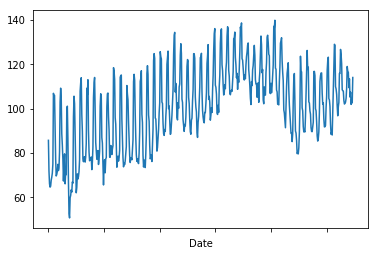

In [3]:
# Look at the first 5 entries and plot the series
df.plot()
df.head(5)

### Transform time series to stationary

In [4]:
def to_stationary(dataset, interval=1):
    '''Routine that takes the original time series
       and remove any trend.'''
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.DataFrame(diff)

In [5]:
def inverse_stationary(history, yhat, interval=1):
    '''Takes the stationary time series and reverts back 
       to original time series with trends.'''
    inverted = list()
    for i in range(0,len(yhat)):
        value = yhat[i] + history[-(len(history)-i)]
        inverted.append(value)
    return pd.DataFrame(inverted)

In [6]:
def inverse_stationary2(history, yhat, interval=1):
    return yhat + history[-interval]

In [7]:
raw_values_stationary = to_stationary(raw_values, 1)
inverted = inverse_stationary(raw_values, raw_values_stationary.values, 1)

In [8]:
print(df.head(5))
print(raw_values_stationary.head(5))
print(inverted.head(5))

Date
1/1/1972    85.6945
2/1/1972    71.8200
3/1/1972    66.0229
4/1/1972    64.5645
5/1/1972    65.0100
Name: IP, dtype: float64
         0
0 -13.8745
1  -5.7971
2  -1.4584
3   0.4455
4   2.6367
         0
0  71.8200
1  66.0229
2  64.5645
3  65.0100
4  67.6467


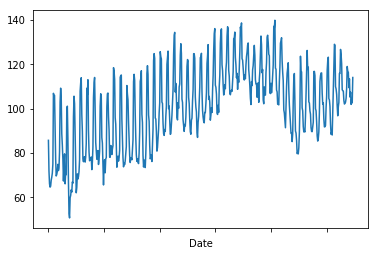

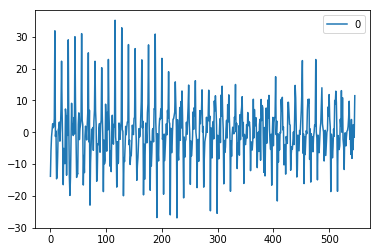

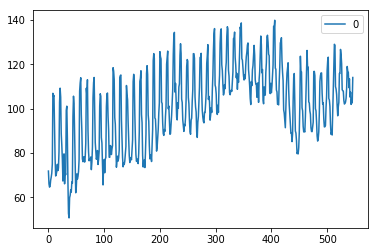

In [9]:
#-- Check by plotting
df.plot()
raw_values_stationary.plot()
inverted.plot()

### Create supervised learning series

In [10]:
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [11]:
supervised = timeseries_to_supervised(raw_values_stationary, lag=1)
supervised_val = supervised.values

### Split train and test sets

In [12]:
splitIdx = int(len(supervised_val) * 0.7)
train, test = supervised_val[0:splitIdx], supervised_val[splitIdx:]
#print(splitIdx)
#print(len(test))

382
165


### Scale the data

In [13]:
def scale(train, test):
    '''Scale the supervised time series data to 
       oscillate between -1 to 1.'''
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler = scaler.fit(train)
    
    # Transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    
    # Transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [14]:
def invert_scale(scaler, X, value):
    '''Reverses the scaling done on the 
       time series data.'''
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0,-1]

In [15]:
scaler, train_scaled, test_scaled = scale(train, test)

### Fit the model

In [16]:
#-- Initialize parameters for LSTM model
look_back       = 1
batch_size      = 1
lbd             = 1e-4    # For l2 regularization
p_drop          = 0.5     # dropout rate for LSTM layer, dropout
p_dropRecurrent = 0.25    # dropout rate for LSTM layer, recurrent dropout
p_dropDense     = 0.1     # dropout rate for Dense layer

#-- Separate sets into X and y components
Xtrain, ytrain = train_scaled[:,0:-1], train_scaled[:,-1]
Xtest, ytest = test_scaled[:,0:-1], test_scaled[:,-1]

#-- Reshape X sets for LSTM model
Xtrain = Xtrain.reshape(Xtrain.shape[0], 1, Xtrain.shape[1])
Xtest = Xtest.reshape(Xtest.shape[0], 1, Xtest.shape[1])

In [17]:
Xtrain[0].shape

(1, 1)

In [18]:
# Functional API
'''
inputs = Input(batch_shape=(batch_size, time_step,1))
lstm = LSTM(4, dropout=p_drop, stateful=True, kernel_regularizer=l2(lbd))(inputs, training=True)
inter = Dropout(p_dropDense)(lstm, training=True)
dense = Dense(1, kernel_regularizer=l2(lbd))(inter)

model = Model(inputs=inputs, outputs=dense)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
'''

'''Note: This turns out to be very slow.'''

"\ninputs = Input(batch_shape=(batch_size, time_step,1))\nlstm = LSTM(4, dropout=p_drop, stateful=True, kernel_regularizer=l2(lbd))(inputs, training=True)\ninter = Dropout(p_dropDense)(lstm, training=True)\ndense = Dense(1, kernel_regularizer=l2(lbd))(inter)\n\nmodel = Model(inputs=inputs, outputs=dense)\nmodel.compile(loss='mean_squared_error', optimizer='adam')\nmodel.summary()\n"

In [19]:
# Sequential API

#-- Construct LSTM model
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back,1), 
               dropout=p_drop, recurrent_dropout=p_dropRecurrent,
               stateful=True, kernel_regularizer=l2(lbd)))
model.add(Dropout(p_dropDense))
model.add(Dense(1, kernel_regularizer=l2(lbd)))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 4)                    96        
_________________________________________________________________
dropout_1 (Dropout)          (1, 4)                    0         
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [20]:
#-- Train the model
model.fit(Xtrain,ytrain, epochs=25, batch_size=batch_size, verbose=2, shuffle=False)

Epoch 1/25
 - 1s - loss: 0.1027
Epoch 2/25
 - 0s - loss: 0.0955
Epoch 3/25
 - 0s - loss: 0.0931
Epoch 4/25
 - 0s - loss: 0.0918
Epoch 5/25
 - 0s - loss: 0.0901
Epoch 6/25
 - 0s - loss: 0.0877
Epoch 7/25
 - 0s - loss: 0.0907
Epoch 8/25
 - 0s - loss: 0.0873
Epoch 9/25
 - 0s - loss: 0.0882
Epoch 10/25
 - 0s - loss: 0.0870
Epoch 11/25
 - 0s - loss: 0.0899
Epoch 12/25
 - 0s - loss: 0.0877
Epoch 13/25
 - 0s - loss: 0.0889
Epoch 14/25
 - 0s - loss: 0.0881
Epoch 15/25
 - 0s - loss: 0.0890
Epoch 16/25
 - 0s - loss: 0.0883
Epoch 17/25
 - 0s - loss: 0.0869
Epoch 18/25
 - 0s - loss: 0.0897
Epoch 19/25
 - 0s - loss: 0.0902
Epoch 20/25
 - 0s - loss: 0.0875
Epoch 21/25
 - 0s - loss: 0.0883
Epoch 22/25
 - 0s - loss: 0.0852
Epoch 23/25
 - 0s - loss: 0.0889
Epoch 24/25
 - 0s - loss: 0.0898
Epoch 25/25
 - 0s - loss: 0.0843


In [21]:
def lstm_forecast(model, batch_size, X):
    '''Takes the trained LSTM model and make
       prediction.'''
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [22]:
#-- Compare the predicted values of LSTM model and original time series

predictions = []
expectations = []
for i in range(0,len(test_scaled)):
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = lstm_forecast(model, 1, X)
    yhat = invert_scale(scaler, X, yhat)
    yhat = inverse_stationary2(raw_values, yhat, len(test_scaled)+1 - i)
    predictions.append(yhat)
    expected = raw_values[len(train) + i]
    expectations.append(expected)
    #print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

0.9818875923074762

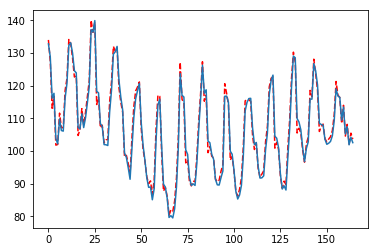

In [23]:
#-- Plot the results
#-- Red, Dashed = LSTM model
#-- Blue = Original time series

plt.plot(predictions,'r--')
plt.plot(expectations)
metrics.r2_score(expectations, predictions)

### Monte Carlo (MC) Dropout for CI Estimates

In [24]:
#-- Define backend function (from Keras) for MC dropout
predict_stochastic = K.function([model.layers[0].input, K.learning_phase()], [model.layers[-1].output])

In [25]:
# Another way to implement MC Dropout
#class MCDropout(keras.layers.Dropout):
#    def call(self, inputs, training=None):
#        return super(MCDropout, self).call(inputs, training=True)

In [26]:
T = 500    # Sample size
yhat_mc = np.array([predict_stochastic([Xtest,1]) for _ in range(T)])
#yhat_mc = np.array([model.predict(Xtest, batch_size=1) for _ in range(T)])
yhat_mc = yhat_mc.reshape(-1, ytest.shape[0]).T
yhat_mc.shape

(165, 500)

In [27]:
l = 10
yhat_test_mean = np.mean(yhat_mc, axis=1)
yhat_test_variance = np.var(yhat_mc, axis=1)
tau = l**2 *(1-p_drop) / (2 * Xtrain.shape[0] * lbd)
yhat_test_variance += tau**-1
yhat_test_mean.shape

(165,)

In [28]:
ytest_mean_inverse=[]
for i in range(0,len(yhat_test_mean)):
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = yhat_test_mean[i]
    yhat = invert_scale(scaler, X, yhat)
    yhat = inverse_stationary2(raw_values, yhat, len(test_scaled)+1 - i)
    ytest_mean_inverse.append(yhat)
    #print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


0.9874083326809411

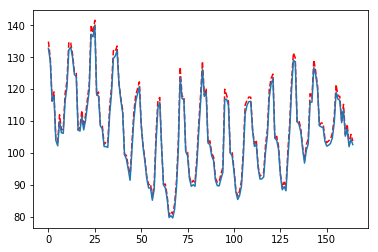

In [29]:
#-- Sanity check: Compare LSTM model from using backend function to original time series
plt.plot(ytest_mean_inverse,'r--')
plt.plot(expectations)
metrics.r2_score(expectations,ytest_mean_inverse)

In [36]:

#-- Look at one of the predictions
month         = 0
monthStr      = raw_keys[len(train) + month]
y_expected = raw_values[len(train) + month]
yhat_test     = yhat_mc[month,:]
yhat          = []
for i in range(0, len(yhat_test)):
    X        = test_scaled[month, 0:-1]
    y     = yhat_test[i]
    y     = invert_scale(scaler, X, y)
    y     = inverse_stationary2(raw_values, y, len(test_scaled)+1 - month)
    yhat.append(y)

### Confidence interval 

In [37]:
#-- Compute statistics
yhat_mc_mean       = np.mean(yhat)
yhat_mse           = np.mean((yhat-yhat_mc_mean)**2.0)
yhat_rmse          = (yhat_mse) ** 0.5
confidence         = 0.95
CI_lower, CI_upper = st.norm.interval(confidence, loc = yhat_mc_mean, 
                                      scale = yhat_rmse)
print('\nMC Dropout prediction at %s' % (monthStr))
print('y_expected: %f' % (y_expected))
print('y_predicted: %f' % (yhat_mc_mean))
print('MSE: %f' % (yhat_mse))
print('RMSE: %f' % (yhat_rmse))
print('95%% CI: (%f, %f)\n' % (CI_lower, CI_upper))


MC Dropout prediction at 11/1/2003
y_expected: 132.790700
y_predicted: 134.923982
MSE: 0.250708
RMSE: 0.500708
95% CI: (133.942612, 135.905351)

